<h1> <center> Exploiting Sentinel-1 SAR time series and neural networks to detect grasslands in the northern Brazilian Amazon</center> </h1>
<center>[Part 2 - Classification]</center>
<br> 
<center>Willian Vieira de Oliveira </center>

## Import required packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

## Neural Network - MLP
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Neural Network - LSTM
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM

## Image visualization
import imageio

from sklearn.impute import SimpleImputer

***
## AUXILIARY FUNCTIONS

#### Open an image

In [9]:
def openImage(filepath):
    data = gdal.Open(filepath)
    return data

#### Convert the prediction array to matrix

In [10]:
def predictionArray_to_matrix(imgPath, class_pred):    
    # Identification of parameters required to create the classification map
    example_img = gdal.Open(imgPath)
    Nrows = example_img.RasterYSize
    Ncols = example_img.RasterXSize
    GeoTransform = example_img.GetGeoTransform()
    Projection = example_img.GetProjection()
    example_img = None

    # Reshaping the classification result
    classif_array = np.reshape(class_pred, (Nrows-6, Ncols-6))

    # In this study, we disconsidered the border pixels (3-pixel length). Therefore, we need to adjust 
    # the array to follow the same characteristics of the example image (GeoTranform and Projection)
    classif_array_adjusted = np.empty((Nrows, Ncols), np.float32)
    classif_array_adjusted[3:Nrows-3, 3:Ncols-3] = classif_array
    
    return classif_array_adjusted, Nrows, Ncols, GeoTransform, Projection

#### Show the classification map

In [11]:
def show_classification_map(classification_matrix, labels, colours):     
    
    #cmap = colors.ListedColormap(['darkgreen', 'palegreen', 'sandybrown'])
    cmap = colors.ListedColormap(colours)

    #classification_matrix = imageio.imread(filename_map)
    plt.figure(figsize = (20,10))
    img = plt.imshow(classification_matrix, cmap=cmap)

    values = np.unique(classification_matrix)

    #handles = [mpatches.Patch(color=colours[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
    handles = [mpatches.Patch(color=colours[i], label=labels[i]) for i in range(len(values))]
    plt.axis('off')
    plt.legend(handles=handles, ncol=len(labels), loc='lower center', fontsize=14, bbox_to_anchor=(0.5, -0.08))

    classification_matrix = None

#### MLP Classification

In [4]:
def MLP_model(X_train, Y_train, X_test, Y_test, hidden_layer_sizes_, max_iter_, solver_, 
              learning_rate_init_, momentum_, alpha_):

    mlp = MLP(hidden_layer_sizes=(hidden_layer_sizes_), max_iter=max_iter_, solver=solver_, 
              learning_rate_init=learning_rate_init_, momentum=momentum_, alpha=alpha_)

    mlp.fit(X_train, Y_train)
    
    Y_train_pred = mlp.predict(X_train)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))
    
    Y_test_pred = mlp.predict(X_test)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))
    
     # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred, Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test

    return mlp, confusion_pred

***
## CLASSIFICATION

I intend to test three classification methods based on Neural Networks:
- MLP
- MLP LSTM
- CNN LSTM Model

In [3]:
labels = ['Forest', 'Grassland', 'Agriculture']
# colours: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
colours = ['darkgreen', 'palegreen', 'sandybrown']

***
### Classification of the original time series (without the extraction of temporal metrics)

In [5]:
imgPath = "DATA/VH_Cube.tif"
pixel_TS = pd.read_csv("DATA/TimeSeries_AllPixels_VH.csv")
sample_TS = pd.read_csv("DATA/TimeSeries_AllSamples.csv")


sample_classes = sample_TS['class'].copy()
sample_TS.drop(labels='class', axis=1, inplace=True) # removing the column 'class' from the dataframe

smp_TS = np.float32(sample_TS)
smp_classes = np.float32(sample_classes)
smp_classes = np.ravel(smp_classes) # converting from column-vector to 1d array (expected by the classifier)
pixels_TS = np.float32(pixel_TS)

In [6]:
test_size_ = 0.4

X_train, X_test, Y_train, Y_test = train_test_split(smp_TS, smp_classes, test_size=test_size_)

scaler = StandardScaler()
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test) 

### MLP

In [7]:
m = 0.8
a = 0
n_hidden_layers = 1000

Generating and evaluating the MLP classification model...


C:\Users\Willian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


    Overall accuracy (resubst): 0.9744
    Overall accuracy (holdout): 0.8833

Classifying the entire dataset (original TS) using the MLP model...

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0.0,193.0,20.0,2.0,NaN,NaN
1.0,16.0,162.0,15.0,NaN,NaN
2.0,2.0,15.0,175.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.974444,0.883333


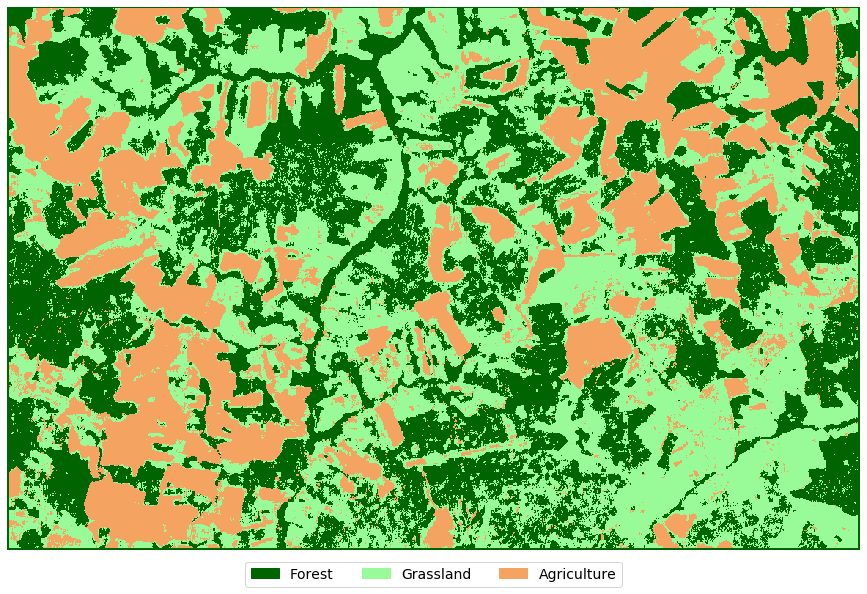

In [12]:
print("Generating and evaluating the MLP classification model...")
mlp, confusion_pred = MLP_model(X_train, Y_train, X_test, Y_test, hidden_layer_sizes_=(n_hidden_layers), 
                                max_iter_=1000, solver_='sgd', learning_rate_init_=0.01, momentum_=m, alpha_=a)

print("\nClassifying the entire dataset (original TS) using the MLP model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ---------------- ANACONDA crushed every time I tried to use the full array (pixels_metrics) ---------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    partial_pred = mlp.predict(arr)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred

***
### MLP/LSTM

#### LSTM Classification


In [14]:
def LSTM_classification(X_train_2, Y_train_2, X_test_2, Y_test_2, n_neurons=50, n_neurons_ouputLayer=3, 
                        training_epochs=50, batch_size=72, verbose=True):
       
    # LSTM model design
    lstm_model = Sequential()
    lstm_model.add(LSTM(n_neurons))
    lstm_model.add(Dense(n_neurons_ouputLayer, activation='softmax'))
    
    lstm_model.compile(loss='mae', optimizer='adam')
    #lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # fit network
    history = lstm_model.fit(X_train_2, Y_train_2, epochs=training_epochs, batch_size=batch_size, 
                              validation_data=(X_test_2, Y_test_2), verbose=verbose, shuffle=False)
    
    return lstm_model, history

#### Reshaping the data

In [28]:
print("Original shape of the training data: ", np.shape(X_train))
print("Original shape of the training targets: ", np.shape(Y_train))

Original shape of the training data:  (900, 31)
Original shape of the training targets:  (900,)


In [18]:
X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], 1, X_test.shape[1])

from tensorflow.python.keras import utils
a_train = utils.to_categorical(Y_train)
a_test = utils.to_categorical(Y_test)

In [29]:
print("New shape of the training data: ", np.shape(X_train_))
print("New shape of the training targets: ", np.shape(a_train))

New shape of the training data:  (900, 1, 31)
New shape of the training targets:  (900, 3)


#### Classification

In [208]:
lstm_model, history = LSTM_classification(X_train_.copy(), X_test_.copy(), a_train.copy(), a_test.copy())

ValueError: Error when checking target: expected dense_27 to have 2 dimensions, but got array with shape (600, 1, 31)